# **Practical Time Series Forecasting with R**
# Chapter 7: Regression-Based Models: Autocorrelations & External Information

In [1]:
## ESTABLISH ENVIRONMENT
# Built-in libraries
from datetime import datetime
from pathlib import Path

# Third-party libraries for data handling and scientific computation
import numpy as np
import pandas as pd

# Libraries for statistical and econometric models
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols
from statsmodels.api import OLS, add_constant
from statsmodels.regression.linear_model import OLS
from statsmodels.tools.tools import add_constant ## Table 6.5
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Libraries for preprocessing and visualization
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.dates as mdates
import matplotlib.pyplot as plt


## AMTRAK IMPORT FORMATTING
def convert_date(date_str):
    # if the string is 'nan' (which can occur if there was a NaN entry in the original data)
    if date_str == 'nan':
        return None
    # try to parse the date assuming it's in the format 'Dec-00'
    try:
        date = datetime.strptime(date_str, '%b-%y')
        if date.year > datetime.now().year:
            date = date.replace(year=date.year-100) # replace century if needed
    except ValueError:
        # if that fails, assume it's in the format '1-Dec'
        try:
            date = datetime.strptime(date_str, '%d-%b')
            # assuming all dates are in 2000s
            date = date.replace(year=2000 + int(date_str.split('-')[0]))
        except ValueError:
            # if both formats fail, return None or handle as you see fit
            return None
    # convert the date into the desired format
    return date.strftime('%B %Y')


## AMTRAK GRAPH FORMATTING
def Amtrak_PlotGraph(train, valid, pred_dict_train, pred_dict_valid, **kwargs):
    TextHight = kwargs.get('TextHight', 2600) # Default value is 2600 if not provided
    fig, ax = plt.subplots()

    # Define color palette with distinct colors
    color_palette = plt.cm.get_cmap('tab10', 10)
    
    ax.plot(train.index, train, label='Training Data', linewidth=2, color=color_palette(0))
    ax.plot(valid.index, valid, label='Validation Data', color=color_palette(0))
    
    for i, (label, pred) in enumerate(pred_dict_train.items()):
        ax.plot(train.index, pred, label=label + ' Training', linewidth=2, linestyle='--', color=color_palette(i+1))  # Using different colors for different models

    for i, (label, pred) in enumerate(pred_dict_valid.items()):
        ax.plot(valid.index, pred, label=label + ' Validation', linewidth=2, linestyle='--', color=color_palette(i+1))  # Using different colors for different models

    ax.axvline(train.index[-1], color='black', linestyle='solid')
    ax.axvline(valid.index[-1], color='black', linestyle='solid')

    ax.text(train.index[int(len(train)/2)], TextHight, 'Training', horizontalalignment='center')
    ax.text(valid.index[int(len(valid)/2)], TextHight, 'Validation', horizontalalignment='center')
    ax.text(valid.index[-1] + pd.DateOffset(months=11), TextHight, 'Future', horizontalalignment='center')
    
    ax.annotate("", xy=(pd.to_datetime('1991-01-01'), TextHight-50), xytext=(train.index[-1], TextHight-50), arrowprops=dict(arrowstyle="<->"))
    ax.annotate("", xy=(train.index[-1], TextHight-50), xytext=(valid.index[-1], TextHight-50), arrowprops=dict(arrowstyle="<->"))
    ax.annotate("", xy=(valid.index[-1], TextHight-50), xytext=(valid.index[-1] + pd.DateOffset(months=20), TextHight-50), arrowprops=dict(arrowstyle="<->"))

    ax.set_xlabel('Time')
    ax.set_ylabel('Ridership')
    ax.set_ylim([1300, 2600])

    years = mdates.YearLocator()
    years_fmt = mdates.DateFormatter('%y')
    ax.xaxis.set_major_locator(years)
    ax.xaxis.set_major_formatter(years_fmt)

    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)

    ax.legend()
    plt.show()

## AMTRAK RESIDUAL FORMATTING
def Amtrak_PlotResidualsGraph(train_residuals, valid_residuals, pred_dict_train_residuals, pred_dict_valid_residuals, **kwargs):
    TextHight = kwargs.get('TextHight', 0) # Default value is 0 if not provided
    fig, ax = plt.subplots()

    # Define color palette with distinct colors
    color_palette = plt.cm.get_cmap('tab10', 10)
    
    ax.plot(train_residuals.index, train_residuals, label='Training Residuals', linewidth=2, color=color_palette(0))
    ax.plot(valid_residuals.index, valid_residuals, label='Validation Residuals', linewidth=2, color=color_palette(0))

    for i, (label, pred_residual) in enumerate(pred_dict_train_residuals.items()):
        ax.plot(train_residuals.index, pred_residual, label=label + ' Training Residuals', linewidth=2, linestyle='--', color=color_palette(i+1))

    for i, (label, pred_residual) in enumerate(pred_dict_valid_residuals.items()):
        ax.plot(valid_residuals.index, pred_residual, label=label + ' Validation Residuals', linewidth=2, linestyle='--', color=color_palette(i+1))
    
    ax.axvline(train_residuals.index[-1], color='black', linestyle='solid')
    ax.axvline(valid_residuals.index[-1], color='black', linestyle='solid')

    ax.text(train_residuals.index[int(len(train_residuals)/2)], TextHight, 'Training', horizontalalignment='center')
    ax.text(valid_residuals.index[int(len(valid_residuals)/2)], TextHight, 'Validation', horizontalalignment='center')
    ax.text(valid_residuals.index[-1] + pd.DateOffset(months=11), TextHight, 'Future', horizontalalignment='center')

    # Add arrows spanning the width of the data periods
    ax.annotate("", xy=(train_residuals.index[0], TextHight-50), xytext=(train_residuals.index[-1], TextHight-50), arrowprops=dict(arrowstyle="<->"))
    ax.annotate("", xy=(train_residuals.index[-1], TextHight-50), xytext=(valid_residuals.index[-1], TextHight-50), arrowprops=dict(arrowstyle="<->"))
    ax.annotate("", xy=(valid_residuals.index[-1], TextHight-50), xytext=(valid_residuals.index[-1] + pd.DateOffset(months=20), TextHight-50), arrowprops=dict(arrowstyle="<->"))

    ax.set_xlabel('Time')
    ax.set_ylabel('Residuals')

    years = mdates.YearLocator()
    years_fmt = mdates.DateFormatter('%y')
    ax.xaxis.set_major_locator(years)
    ax.xaxis.set_major_formatter(years_fmt)

    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)

    ax.legend()
    plt.show()


### IMPORTING DATA ###

# Define Path
Data_Repo = Path("/Users/[Insert Path to Data]/")

#Data
Amtrak_data = pd.read_csv(Data_Repo / "Amtrak data.csv", skipfooter=96, skip_blank_lines=True, comment='#', engine='python')
Amtrak_data['Month'] = Amtrak_data['Month'].astype(str) # Convert the 'Month' column to string type
Amtrak_data['Month'] = Amtrak_data['Month'].apply(convert_date) # Apply the date conversion function to the 'Month' column

tumblr_data = pd.read_csv(Data_Repo / "Tumblr.csv")
people_ts = tumblr_data['People Worldwide'] / 1000000
bike_hourly_df = pd.read_csv(Data_Repo / "BikeSharingHourly.csv" )  
bike_df = pd.read_csv(Data_Repo / "BikeSharingDaily.csv" )  
one_pair = pd.read_csv(Data_Repo / "Walmart_One_Pair.csv" )  

##Ch2 >> Amtrak TimeSeries
ridership_ts = pd.Series(Amtrak_data["Ridership"].values, index=pd.date_range('1991-01', periods=len(Amtrak_data), freq='M'))
ridership_df = pd.DataFrame(Amtrak_data["Ridership"].values, index=pd.date_range('1991-01', periods=len(Amtrak_data), freq='M'), columns=['ridership'])


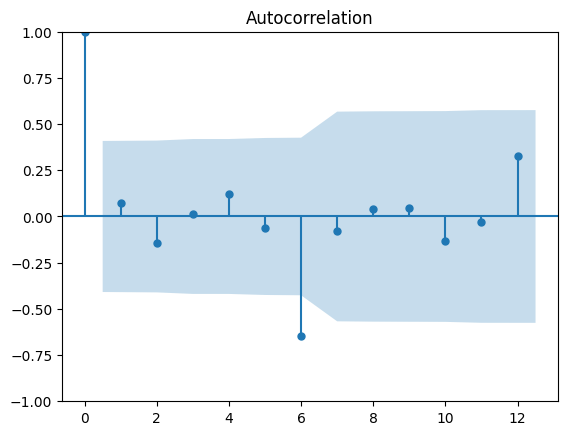

In [2]:
## Figure 7.2: Acf output showing autocorrelations at lags 1-12 for first 24 months
from statsmodels.graphics.tsaplots import plot_acf

# Create a 24-month window from the original time series
start_date = pd.Timestamp('1991-01')
end_date = start_date + pd.DateOffset(months=23)
ridership_24_ts = ridership_ts.loc[start_date:end_date]

# Plot autocorrelation
plot_acf(ridership_24_ts, lags=12)
plt.show()


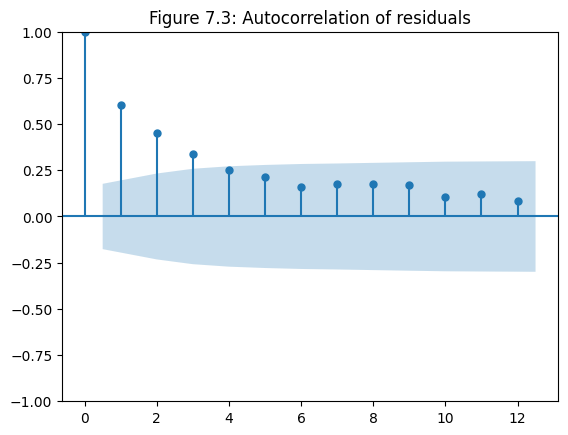

[1.         0.60405883 0.44983171 0.3373083  0.25329034 0.21565844
 0.15901326 0.17676683 0.17553762 0.17140882 0.10739472 0.11976519
 0.08512942]


In [4]:
## Figure 7.3: Acf output of autocorrelations of residual series from fig. 6.7
from statsmodels.tsa.stattools import acf

# Define the size of your validation set
nValid = 36
nTrain = len(ridership_ts) - nValid

# Split your data into training and validation sets
train = ridership_ts.iloc[:nTrain]
valid = ridership_ts.iloc[nTrain:nTrain + nValid]

# Define your trend variables
train_trend = pd.Series(np.arange(len(train)), index=train.index)
valid_trend = pd.Series(np.arange(nTrain, nTrain + nValid), index=valid.index)

# Create your polynomial features
poly = PolynomialFeatures(degree=2, include_bias=False)
train_trend_poly = pd.DataFrame(poly.fit_transform(train_trend.values.reshape(-1, 1)), index=train.index)
valid_trend_poly = pd.DataFrame(poly.transform(valid_trend.values.reshape(-1, 1)), index=valid.index) 

# Add month columns to your datasets
train_month = pd.DataFrame(train.index.month, index=train.index, columns=['month'])
valid_month = pd.DataFrame(valid.index.month, index=valid.index, columns=['month'])

# Create dummy variables for your month columns
train_month_dummies = pd.get_dummies(train_month.month, prefix='month')
valid_month_dummies = pd.get_dummies(valid_month.month, prefix='month')

# Combine your polynomial trend features and your seasonality features
train_combined = pd.concat([train_trend_poly, train_month_dummies], axis=1)
valid_combined = pd.concat([valid_trend_poly, valid_month_dummies], axis=1)

# Convert boolean to int
train_combined = train_combined.astype(int)
valid_combined = valid_combined.astype(int)

# Fit your model to the combined features
train_combined = add_constant(train_combined)
valid_combined = add_constant(valid_combined)
model_trend_season = OLS(train, train_combined).fit()

# Make predictions with your model
pred_trend_season = model_trend_season.predict(valid_combined)

# Calculate the residuals of the model
residuals = train - model_trend_season.predict(train_combined)

# Plot the autocorrelation of the residuals
plot_acf(residuals, lags=12)
plt.title("Figure 7.3: Autocorrelation of residuals")
plt.show()

# see acf values
acf_values = acf(residuals, nlags=12)
print ( acf_values )

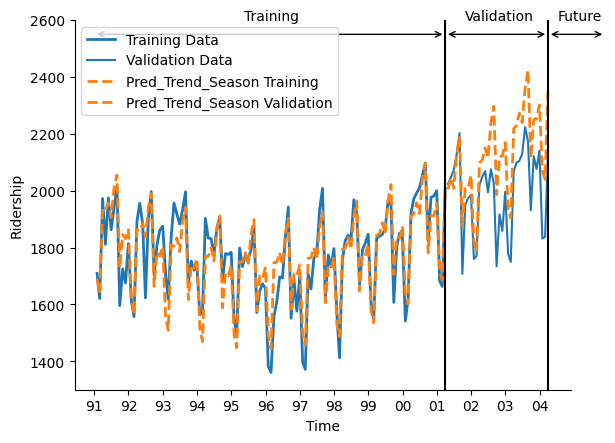

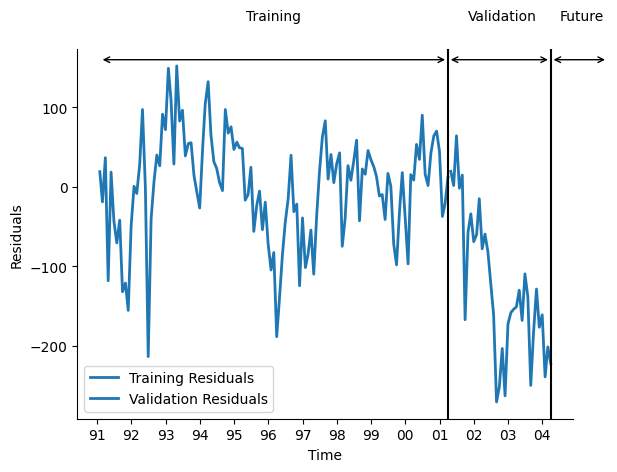

In [3]:
## Required for Figure 7.4 (i.e., Run Figure 6.7)

# Define the size of your validation set
nValid = 36
nTrain = len(ridership_ts) - nValid

# Split your data into training and validation sets
train = ridership_ts.iloc[:nTrain]
valid = ridership_ts.iloc[nTrain:nTrain + nValid]

# Define your trend variables
train_trend = pd.Series(np.arange(len(train)), index=train.index)
valid_trend = pd.Series(np.arange(nTrain, nTrain + nValid), index=valid.index)

# Create your polynomial features
poly = PolynomialFeatures(degree=2, include_bias=False)
train_trend_poly = pd.DataFrame(poly.fit_transform(train_trend.values.reshape(-1, 1)), index=train.index)
valid_trend_poly = pd.DataFrame(poly.transform(valid_trend.values.reshape(-1, 1)), index=valid.index) 

# Add month columns to your datasets
train_month = pd.DataFrame(train.index.month, index=train.index, columns=['month'])
valid_month = pd.DataFrame(valid.index.month, index=valid.index, columns=['month'])

# Create dummy variables for your month columns
train_month_dummies = pd.get_dummies(train_month.month, prefix='month')
valid_month_dummies = pd.get_dummies(valid_month.month, prefix='month')

# Combine your polynomial trend features and your seasonality features
train_combined = pd.concat([train_trend_poly, train_month_dummies], axis=1)
valid_combined = pd.concat([valid_trend_poly, valid_month_dummies], axis=1)

# Convert boolean to int
train_combined = train_combined.astype(int)
valid_combined = valid_combined.astype(int)

# Fit your model to the combined features
train_combined = add_constant(train_combined)
valid_combined = add_constant(valid_combined)
model_trend_season = OLS(train, train_combined).fit()

# Make predictions with your model
pred_trend_season = model_trend_season.predict(valid_combined)

# Store your predictions
pred_dict_train = {'Pred_Trend_Season': model_trend_season.fittedvalues}
pred_dict_valid = {'Pred_Trend_Season': pred_trend_season}

# Visualize your predictions
Amtrak_PlotGraph(train, valid, pred_dict_train, pred_dict_valid, TextHight=2600)

## RESIDUALS
# Calculate & Store residuals|predictions
train_residuals = train - model_trend_season.fittedvalues
valid_residuals = valid - pred_trend_season
pred_dict_train_residuals = {}
pred_dict_valid_residuals = {}

# Visualize Residuals
Amtrak_PlotResidualsGraph(train_residuals, valid_residuals, pred_dict_train_residuals, pred_dict_valid_residuals, TextHight=210)

# ## Table 6.4: Summary of output from fitting model with Quadratic trend & seasonlity to Amtrak ridership data
# print (model_trend_season.summary()) 


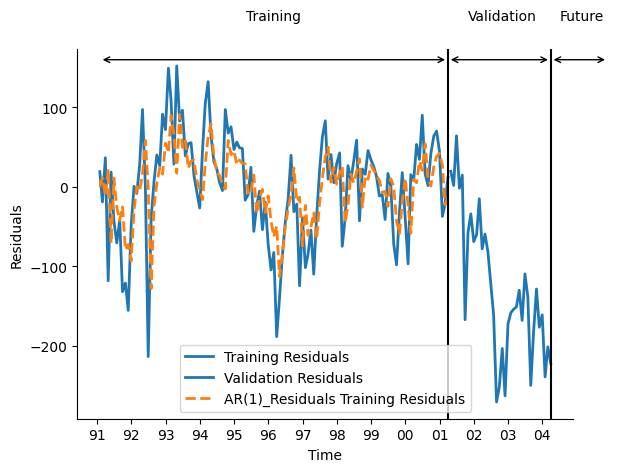

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  123
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -663.542
Date:                Thu, 03 Aug 2023   AIC                           1333.084
Time:                        15:25:24   BIC                           1341.521
Sample:                    01-31-1991   HQIC                          1336.511
                         - 03-31-2001                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0328     13.039      0.003      0.998     -25.522      25.588
ar.L1          0.5998      0.076      7.901      0.000       0.451       0.749
sigma2      2828.8236    291.611      9.701      0.0

In [4]:
## Figure 7.4: Fitting AR(1) model to residual series
    ## Run fig/model 6.7 first (above)
from statsmodels.tsa.arima.model import ARIMA

# Fit AR(1) model to residuals
model_res = ARIMA(train_residuals, order=(1, 0, 0)).fit()

# Make predictions with your AR(1) model
pred_res_train = model_res.predict(start=train_residuals.index[0], end=train_residuals.index[-1])
pred_res_valid = model_res.predict(start=valid_residuals.index[0], end=valid_residuals.index[-1])

# Store AR(1) predictions
pred_dict_train_residuals = {'AR(1)_Residuals': pred_res_train}
pred_dict_valid_residuals = {}

# Plot Residuals with AR(1) model prediction
Amtrak_PlotResidualsGraph(train_residuals, valid_residuals, pred_dict_train_residuals, pred_dict_valid_residuals, TextHight=210)

#Print Model Summary
print (model_res.summary()) 


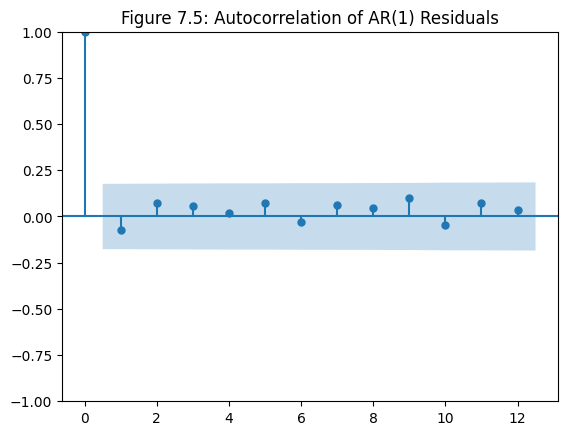

In [7]:
##Figure 7.5: Autocorrelations of residuals-of-residuals
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(model_res.resid, lags=12)
plt.gca().set_title("Figure 7.5: Autocorrelation of AR(1) Residuals")
plt.show()


                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.844
Model:                            OLS   Adj. R-squared:                  0.838
Method:                 Least Squares   F-statistic:                     144.8
Date:                Thu, 03 Aug 2023   Prob (F-statistic):          4.81e-231
Time:                        15:25:50   Log-Likelihood:                -5160.3
No. Observations:                 641   AIC:                         1.037e+04
Df Residuals:                     617   BIC:                         1.048e+04
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------

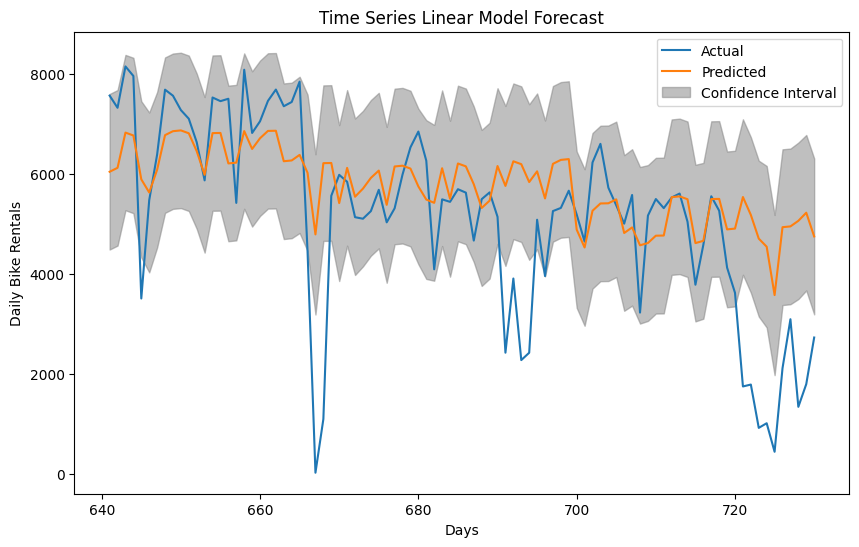

In [5]:
## Table 7.1: Code for fitting time series linear model to daily Bike Sharing data with external weather information >> Trend & Monthly|Day-Of-Week Seasonlity
## Table 7.2: Output of Time Series Linear Model 
## Figure 7.6: Forecasts from time series linear model fit to daily Bike Sharing data
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

bike_df = pd.read_csv(Data_Repo / "BikeSharingDaily.csv" )

# Prepare the data
bike_df['Date'] = pd.to_datetime(bike_df['dteday'])
bike_df['Month'] = bike_df['Date'].dt.strftime('%b')
bike_df['DOW'] = bike_df['Date'].dt.day_name()
bike_df['WorkingDay'] = bike_df['workingday'].map({0: 'Not_Working', 1: 'Working'})
bike_df['Weather'] = bike_df['weathersit'].map({1: 'Clear', 2: 'Mist', 3: 'Rain_Snow'})

# Create interaction terms
bike_df['WorkingDay_Weather'] = bike_df['WorkingDay'] + "_" + bike_df['Weather']

# One-Hot Encoding for categorical features
bike_df = pd.get_dummies(bike_df, columns=['Month', 'DOW', 'WorkingDay', 'Weather', 'WorkingDay_Weather'], drop_first=True)

# Convert to int
for col in bike_df.columns:
    if 'Month_' in col or 'DOW_' in col or 'WorkingDay_Weather_' in col:
        bike_df[col] = bike_df[col].astype(int)

# Trend Component
bike_df['Trend'] = np.arange(len(bike_df))

# Combine all data
y = bike_df['cnt']
x = bike_df[[col for col in bike_df.columns if 'Month_' in col or 'DOW_' in col or 'WorkingDay_Weather_' in col or col == 'Trend']]

# Create train and validation sets
n_total = len(y)
n_valid = 90
n_train = n_total - n_valid
x_train = x[:n_train]
y_train = y[:n_train]
x_valid = x[n_train:]
y_valid = y[n_train:]

# Fit the model (Note: lambda = 1 means no transformation)
mod = sm.OLS(y_train, sm.add_constant(x_train))
res = mod.fit()

# Print the summary >> Different from R, however graph & metrics below match
print(res.summary())

# Make predictions
y_pred = res.predict(sm.add_constant(x_valid))

# Calculate confidence intervals for new observations
_, pred_lower, pred_upper = wls_prediction_std(res, sm.add_constant(x_valid))

# Calculate the metrics
mse = mean_squared_error(y_valid, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_valid, y_pred)
mape = mean_absolute_percentage_error(y_valid, y_pred) * 100  # scale to percentage
me = np.mean(y_valid - y_pred)
mpe = np.mean((y_valid - y_pred) / y_valid) * 100

print(f'Mean Error (ME): {me}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Percentage Error (MPE): {mpe}')
print(f'Mean Absolute Percentage Error (MAPE): {mape}')

# Plot the predictions, actual values and confidence intervals
plt.figure(figsize=(10,6))
plt.plot(y_valid.index, y_valid, label='Actual')
plt.plot(y_valid.index, y_pred, label='Predicted')
plt.fill_between(y_valid.index, pred_lower, pred_upper, color='gray', alpha=0.5, label='Confidence Interval')
plt.xlabel('Days')
plt.ylabel('Daily Bike Rentals')
plt.title('Time Series Linear Model Forecast')
plt.legend()
plt.show()



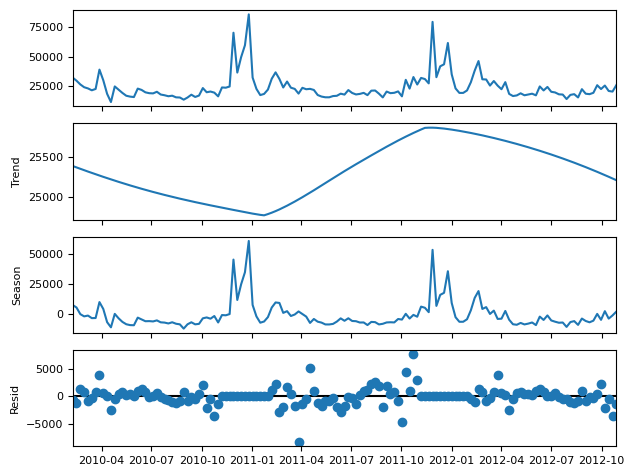

In [13]:
## Figure 7.7: Decomposition of Walmart weekly sales using R stl
    ## Date Range Updated per Galit Shmueli 7/12/23
from statsmodels.tsa.seasonal import STL

n_train = 143

# Create date range for your data, starting from the fifth week of 2010
dates = pd.date_range(start='2010-02-01', periods=len(one_pair['Weekly_Sales']), freq='W')

# Create a pandas series for your training data
y_train = pd.Series(one_pair['Weekly_Sales'][0:n_train].values, index=dates[0:n_train])

# Decompose the time series into seasonal, trend, and residual components
stl = STL(y_train, period=52)
result = stl.fit()

# Set the size of the text
plt.rcParams.update({'font.size': 8})

# Plot the decomposed time series
fig = result.plot()
plt.show()


In [47]:
## Table 7.3
one_pair['IsHoliday'] = one_pair['IsHoliday'].astype(int)
n_test = 39
x_train = one_pair['IsHoliday'][0:n_train].values.reshape(-1, 1)
x_test = one_pair['IsHoliday'][n_train:n_train+n_test].values.reshape(-1, 1)

## STLM approach
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import acf
from sklearn.linear_model import LinearRegression

# Decompose the time series into seasonal, trend, and residual components
stl = STL(y_train, period=52)
result = stl.fit()

# Detrend the time series
detrended = result.trend
y_train_detrended = y_train - detrended

# Create a linear regression model
model = LinearRegression()
model.fit(x_train, y_train_detrended)

# Forecast
forecast = model.predict(x_test)

# Reapply the trend
forecast = forecast + result.trend[-n_test:]

## Equivalent alternative approach to STLM
# Fit ARIMA model to the de-seasonalized time series
arima_model = ARIMA(y_train_detrended, order=(2,0,1), exog=x_train) ## Based on R output
arima_fit = arima_model.fit()

print(arima_fit.summary())

# Predict future values
arima_pred = arima_fit.predict(start=n_train, end=n_train+n_test-1, exog=x_test)

# Reapply the trend
arima_pred = arima_pred + result.trend[-n_test:]

# Print the difference between the forecasts
print('Forcast Deltas: ', np.nansum(forecast - arima_pred)) ## Sum to see no deltas between forecasts (Note, Nan values in ARIMA)


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  143
Model:                 ARIMA(2, 0, 1)   Log Likelihood               -1504.323
Date:                Wed, 02 Aug 2023   AIC                           3020.646
Time:                        11:38:23   BIC                           3038.423
Sample:                    02-07-2010   HQIC                          3027.870
                         - 10-28-2012                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -2073.5000   3170.797     -0.654      0.513   -8288.149    4141.149
x1          1.436e+04   1486.517      9.663      0.000    1.15e+04    1.73e+04
ar.L1          0.4362      0.373      1.171      0.2

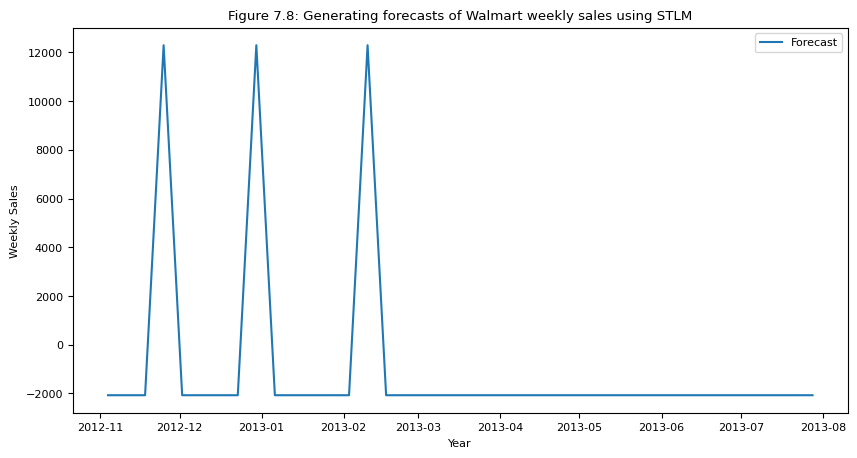

In [48]:
## Figure 7.8 (Not same output)

# Calculate forecast
forecast = model.predict(x_test)

# Create a date range for the forecast
forecast_dates = dates[n_train:n_train+n_test]

# Plot the forecast
plt.figure(figsize=(10, 5))
plt.plot(forecast_dates, forecast, label='Forecast')

plt.xlabel('Year')
plt.ylabel('Weekly Sales')
plt.title('Figure 7.8: Generating forecasts of Walmart weekly sales using STLM')
plt.legend()
plt.show()
